# Swing prediction: EDA

Predicting when a batter is more likely to swing can be useful for a pitcher. For instance, it can be useful to determine how likely a batter will swing on a full count. If he is inclined to swing, then the batter could be suceptible to pitches out of the strike zone.

Here, I'll look at possible variables that could be used to predicting whether a batter will swing at a pitch or not.

In [1]:
# imports
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sqlite3
import subprocess
%matplotlib inline

## Loading data and creating the response

I'll start by loading in pitch information from where a given batter is hitting. For now, I'll start with Jack Cust, who was known for three things: hitting home runs, walks, and striking out.

In [2]:
# specify database name
dbname = "../dat/pitchfx2008.db"

# connect to the sqlite3 database
db = sqlite3.connect(dbname)
hdb = db.cursor()

In [3]:
# import classes
sys.path.append('../src')
from Player import Player

# create player object
jc = Player("Jack Cust", db)

# grab pitches
jc_pitches = jc.pitches_against(clean=1).reset_index(drop=False)
# grab events
jc_events = jc.hit_events()
# grab games
jc_games = jc.hit_games()

Now that I have loaded and cleaned the data, I'll create the response, which is whether the batter swung at the pitch or not. I'll first create a chart of the pitch outcomes.

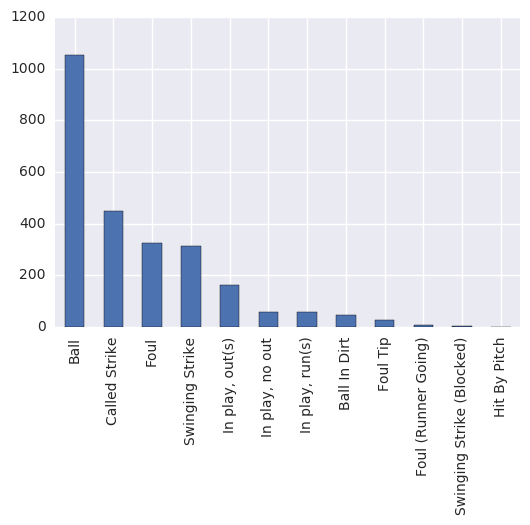

In [4]:
# pitch outcome distribution
plt.subplots()
jc_pitches['description'].value_counts().plot.bar()
plt.show()

Clearly, I'll need to divide these data into two categories: swings and not swings.

In [5]:
# list of swing outcomes
swings = ['Swinging Strike',
          'In play, out(s)',
          'In play, no out',
          'In play, run(s)',
          'Foul',
          'Foul Tip',
          'Foul (Runner Going)',
          'Swinging Strike (Blocked)']

# create feature of swings in pitches
jc_pitches['swing'] = np.array(list(map(lambda x: x in swings, jc_pitches['description'])))

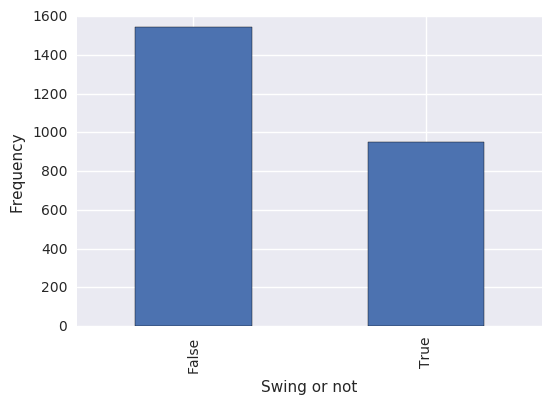

percentage of pitches swung at:  0.381352541016


In [6]:
# histogram of swings and not swings
jc_pitches['swing'].value_counts().plot.bar()
plt.xlabel('Swing or not')
plt.ylabel('Frequency')
plt.show()

# percentage of swings
print("percentage of pitches swung at: ", np.mean(jc_pitches['swing']))

Cust swings at less than half the pitches he sees. Specifically, he swings at 38% of the pitches he sees, which could be the baseline error rate for this problem.

## Data exploration

Here, I'll look more closely at how the decision to swing might be related to some of the data in the database. In particular, I'll look at pitcher handedness, pitch location, and pitch trajectory.

### Pitcher handedness

I'll add pitcher handedness to the dataframe first.

In [7]:
# get player table
query = """SELECT *
        FROM players
        """
players = pd.read_sql_query(query, db)

# join pitcher handedness
handedness = jc_pitches.merge(jc_events,
                              left_on=['game_id', 'cur_event'],
                              right_on=['game_id', 'event_id'],
                              how='left',) \
                       .merge(players[['player_id', 'throws']].drop_duplicates(),
                              left_on=['pitcher_id'],
                              right_on=['player_id'],
                              how='left') \
                       .sort_values(by=['game_id', 'cur_event'])['throws']
        
handedness[handedness=='L'] = 0
handedness[handedness=='R'] = 1
jc_pitches['pitcher_handedness'] = handedness

Now I'll compare the percent of pitches Cust swings at depending on pitcher handedness.

In [54]:
# swing rates based on handedness
vals = jc_pitches.groupby('pitcher_handedness')['swing'].aggregate(['mean', 'count'])
print(vals)

                        mean  count
pitcher_handedness                 
0                   0.357453    691
1                   0.390487   1808


Cust swings at a higher percentage of pitches from lefties (0) than righties (1), though he face a lot more righties than lefties.

I'll quickly test whether these percentages are significantly different using the hypothesis testing approach in https://onlinecourses.science.psu.edu/stat414/node/268. To take this approach, I am assuming that the two population proportions are independent. The null hypothesis is that the proportion pitches swung at is the same against both lefties and righties. I'll perform a two-tailed test here.

In [56]:
# imports
from scipy.stats import norm

# calculate sample parameters
nL = len(jc_pitches[handedness==0])
nR = len(jc_pitches[handedness==1])
pswingR = vals.iloc[0, 0]
pswingL = vals.iloc[1, 0]
pswingTOT = np.mean(jc_pitches['swing'])

# calculate test statistic
Znum = abs(pswingR-pswingL)
Zden = np.sqrt( (pswingTOT*(1-pswingTOT)) * ((1/nL)+(1/nR)) )
Z = Znum/Zden

# calculate P-value
pval = 2*(1-norm.cdf(Z))
print("p-val: ", pval)

p-val:  0.128348660416


This p-value indicates that under the assumption that the proportion of pitches swung at is the same against both righties and lefties, there is a 12% probability that these proportions would be observed by chance. By most typical significance levels, a p-value of 0.12 is not enough to reject the null hypothesis that the proportion of pitches swung at is the same against both righties and lefties. Regardless, I'll keep the pitcher handedness as a feature, as it could possibly be important when combined by other features.

### Pitch location

I'll plot scatterplots of pitches swung at and not swung at with respect to strike zone location and pitcher handedness.

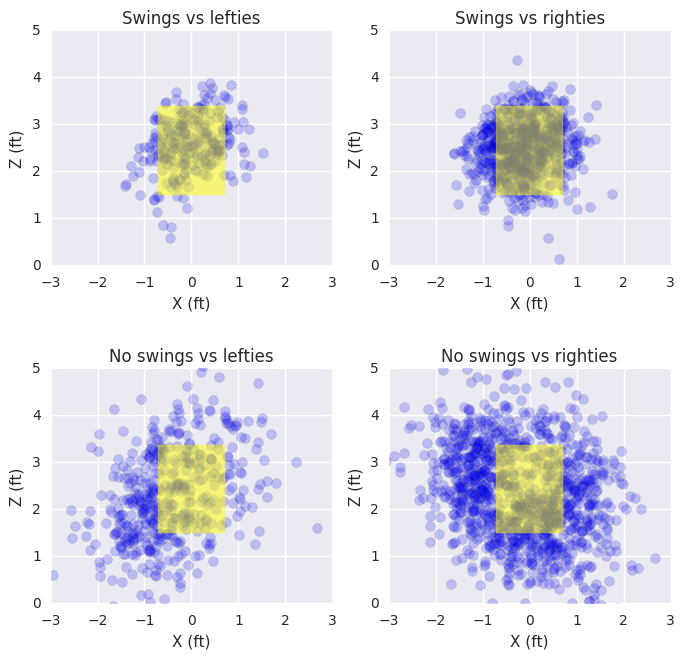

In [10]:
# strike zone dimensions
sz_top = jc_pitches['sz_top'].iloc[0]
sz_bot = jc_pitches['sz_bot'].iloc[0]
sz_left = -8.5/12
sz_right = 8.5/12

# create lists for plots
info = [jc_pitches[jc_pitches['swing']==1], jc_pitches[jc_pitches['swing']==0]]

# plot where pitches cross the plate by handedness
ncol = 2
nrow = 2
titles = [['Swings vs lefties', 'Swings vs righties'],
          ['No swings vs lefties', 'No swings vs righties']]
fig, ax = plt.subplots(ncol, nrow, figsize=(8, 8))

# plot
for ii in range(nrow):
    for jj in range(ncol):
        datax = info[ii]['px']
        dataz = info[ii]['pz']
        ax[ii, jj].scatter(datax[info[ii]['pitcher_handedness']==jj],
                           dataz[info[ii]['pitcher_handedness']==jj],
                           alpha=0.2,
                           s=50,
                           cmap='jet')
        ax[ii, jj].add_patch(plt.Rectangle((sz_left, sz_bot),
                                           sz_right-sz_left,
                                           sz_top-sz_bot,
                                           color='yellow',
                                           alpha=0.5),)
        ax[ii, jj].set_title(titles[ii][jj])
        ax[ii, jj].set_xlabel('X (ft)')
        ax[ii, jj].set_ylabel('Z (ft)')
        ax[ii, jj].set_xlim(-3, 3)
        ax[ii, jj].set_ylim(0, 5)
        ax[ii, jj].set_aspect('equal')

plt.show()

Note that these results might be biased because there are fewer left-handed than right-handed pitchers. With that in mind, it appears that Cust gets a lot of pitches down and away from lefties and does a pretty decent job laying off of that pitch. Cust might also seems to lay off of pitches down and in in the strike zone from righties.

I'll now look at the stacked histograms of these plots to try to gain more insight.

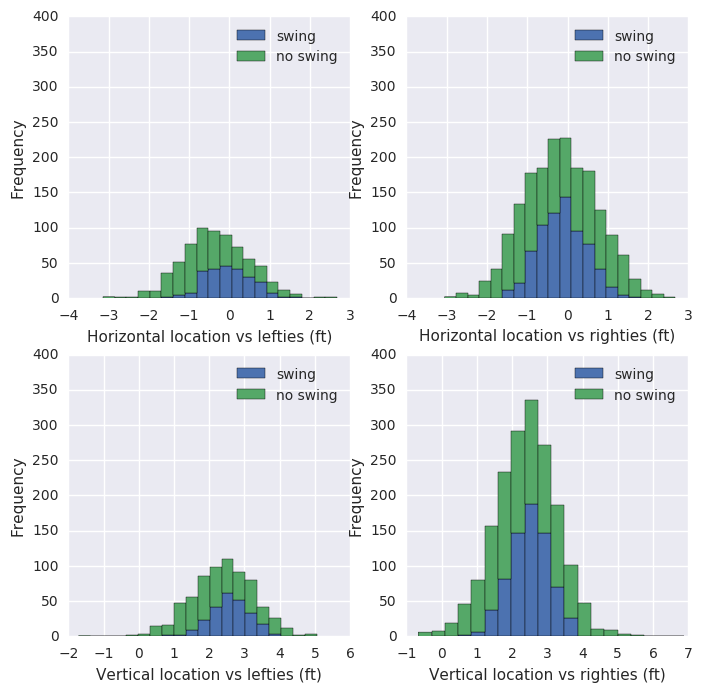

In [24]:
# bin parameters
nbins = 20
nrow = 2
ncol = 2
xlabels = [['Horizontal location vs lefties (ft)', 'Horizontal location vs righties (ft)'],
           ['Vertical location vs lefties (ft)', 'Vertical location vs righties (ft)']]
toplot = ['px', 'pz']

# stacked histograms
fig, ax = plt.subplots(nrow, ncol, figsize=(8, 8))

# strike zone location
for ii in range(nrow):
    for jj in range(ncol):
        data_swing = info[0][toplot[ii]]
        data_noswing = info[1][toplot[ii]]
        pd.concat([data_swing[info[0]['pitcher_handedness']==jj],
                  data_noswing[info[1]['pitcher_handedness']==jj]],
                  axis=1).plot.hist(stacked=True,
                                    ax=ax[ii, jj],
                                    bins=nbins)
        ax[ii, jj].set_xlabel(xlabels[ii][jj])
        ax[ii, jj].legend(['swing', 'no swing'])
        ax[ii, jj].set_ylim(0, 400)

plt.show()

Cust tends to not swing at pitches down and away from lefties, at least compared to righties. There doesn't seem to be as clear a pattern with respect to vertical location. Regardless, pitch location is likely to play a major role in predicting whether the batter swings or not, as most batters try to swing at pitches in the zone.

### Pitch trajectory

Certain players could be more likely to swing at fastballs. I'll look into whether Cust is likely to take a pitch based on the ball's trajectory. From previous work with pitch classification, three important features for determining ball trajectory are velocity and accelerations. I'll begin by plotting the swing percentage of pitches based on velocity, accelerations, and pitcher handedness.

In [12]:
# import plotting
import sys
sys.path.append('../src')
from xplot3 import xplot3

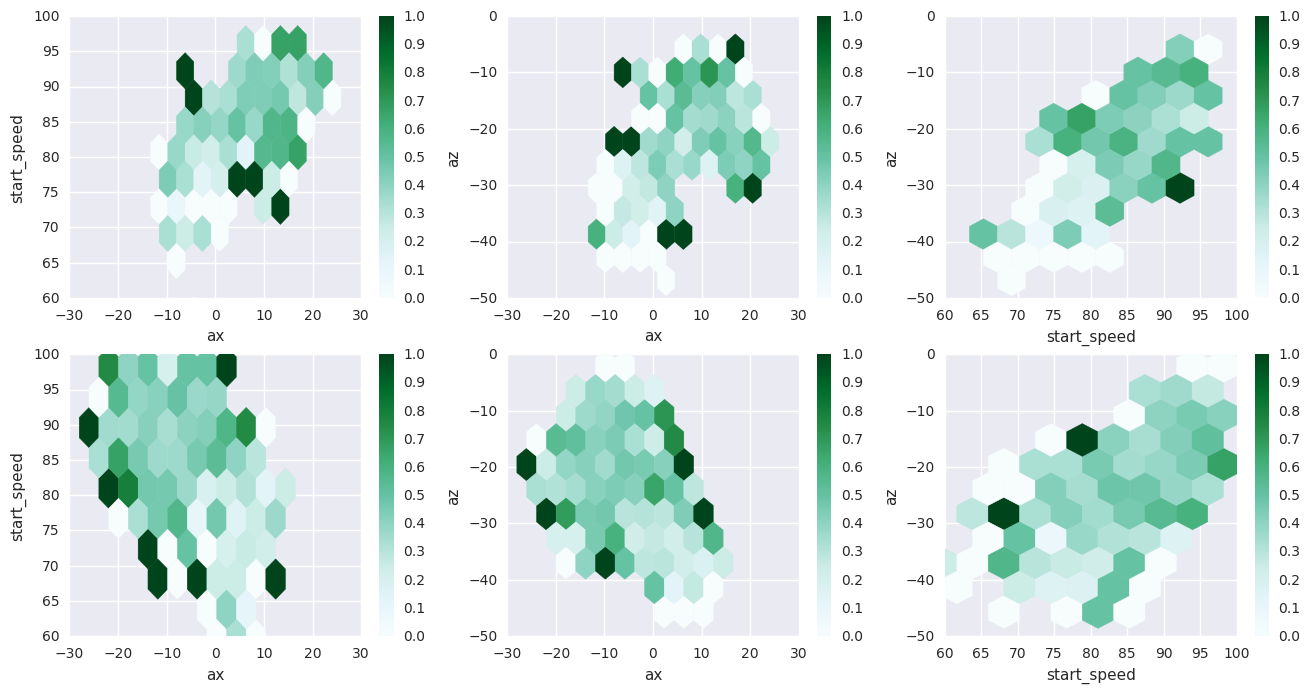

In [61]:
# set plot limits
axlim = (-30, 30)
azlim = (-50, 0)
vlim = (60, 100)
gsize = 10

# plot densities
fig, ax = plt.subplots(2, 3, figsize=(16, 8))
jc_pitches[handedness==0].plot.hexbin('ax', 'start_speed', C='swing', gridsize=gsize, xlim=axlim, ylim=vlim, ax=ax[0, 0])
jc_pitches[handedness==1].plot.hexbin('ax', 'start_speed', C='swing', gridsize=gsize, xlim=axlim, ylim=vlim, ax=ax[1, 0])
jc_pitches[handedness==0].plot.hexbin('ax', 'az', C='swing', gridsize=gsize, xlim=axlim, ylim=azlim, ax=ax[0, 1])
jc_pitches[handedness==1].plot.hexbin('ax', 'az', C='swing', gridsize=gsize, xlim=axlim, ylim=azlim, ax=ax[1, 1])
jc_pitches[handedness==0].plot.hexbin('start_speed', 'az', C='swing', gridsize=gsize, xlim=vlim, ylim=azlim, ax=ax[0, 2])
jc_pitches[handedness==1].plot.hexbin('start_speed', 'az', C='swing', gridsize=gsize, xlim=vlim, ylim=azlim, ax=ax[1, 2])
plt.show()

The top row corresponds to lefties and the bottom row to righties. A value of 1 means that the batter swung at all pitches with that velocity and/or acceleration(s), while a value of 0 means that the batter didn't swing at any of those pitches. In general, it looks like Cust lays off a higher percentage of off-speed and breaking pitches from lefties than from righties.

However, there are likely fewer pitches in the lower velocity bins (fastballs are more similar in trajectory than slower breaking balls from pitcher to pitcher), making these swing rates potentially misleading. I'll create stacked histograms of swings and misses with respect to these three parameters to compare how often balls are thrown with these trajectories.

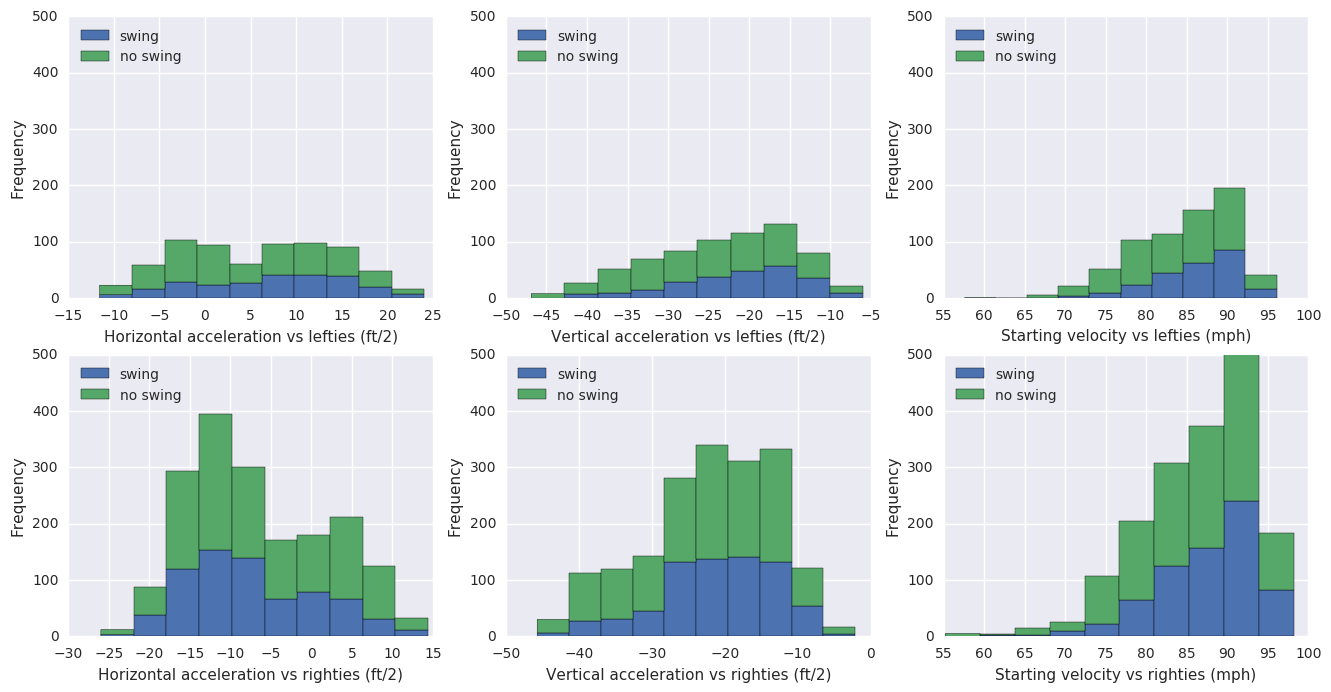

In [65]:
# bin parameters
nbins = 10
nrow = 2
ncol = 3
xlabels = [['Horizontal acceleration vs lefties (ft/2)',
            'Vertical acceleration vs lefties (ft/2)',
            'Starting velocity vs lefties (mph)'],
           ['Horizontal acceleration vs righties (ft/2)',
            'Vertical acceleration vs righties (ft/2)',
            'Starting velocity vs righties (mph)']]
toplot = ['ax', 'az', 'start_speed']

# stacked histograms
fig, ax = plt.subplots(nrow, ncol, figsize=(16, 8))

# strike zone location
for ii in range(nrow):
    for jj in range(ncol):
        data_swing = info[0][toplot[jj]]
        data_noswing = info[1][toplot[jj]]
        pd.concat([data_swing[info[0]['pitcher_handedness']==ii],
                  data_noswing[info[1]['pitcher_handedness']==ii]],
                  axis=1).plot.hist(stacked=True,
                                    ax=ax[ii, jj],
                                    bins=nbins)
        ax[ii, jj].set_xlabel(xlabels[ii][jj])
        ax[ii, jj].legend(['swing', 'no swing'], loc=2)
        ax[ii, jj].set_ylim(0, 500)

plt.show()

From these plots, it appears that Cust sees fewer breaking balls (high negative vertical acceleration, low velocity) from lefties than righties, as expected. There are enough pitches in each bin to suggest that he doesn't swing at breaking pitches as often against lefties than against righties. Thus, pitch trajectory could be a useful feature in swing prediction.

### Situational features

Besides the actual trajectory and location of the pitch, a batter may be more inclined to swing at pitches depending on what the situation is in the game. For instance, if there's a runner on third with no outs, a batter may be more inclined to be aggressive with the bat to try to get the run home. If the count is full, maybe a batter will be more susceptible to chasing pitches outside of the strike zone. I'll create a table of potential situational features, and look at swing rates based on the number of outs

In [18]:
# join events and pitches
extras = jc_pitches.merge(jc_events,
                          left_on=['game_id', 'cur_event'],
                          right_on=['game_id', 'event_id'],
                          how='left')

In [19]:
# situational features
# pitch count
X2 = pd.concat([jc_pitches['pre_balls'], jc_pitches['pre_strike']], axis=1)
# outs
X2['outs'] = extras['pre_out']

# swing or not (the response)
X2['swing'] = jc_pitches['swing']

I'll start by looking at swing rates based on the number of outs.

In [20]:
# get swing rates and number of at bats with outs
vals = X2.groupby('outs')['swing'].aggregate(['mean', 'count'])
print(vals)

          mean  count
outs                 
0     0.409779    859
1     0.369650    771
2     0.363636    869


It appears that Cust is more likely to swing at a pitch if there are no outs when he's hitting, suggesting he is an aggressive 0-out hitter.

I'll also look at Cust's swing rate based on the count. Instead of treating balls and stikes independently, I'll look at the count differential, which I'll define as the difference between the number of balls and strikes. If the number is positive, there are currently more balls than strikes, which suggests a hitter's count.

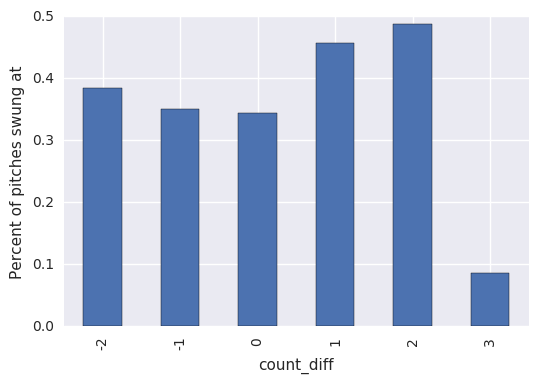

                mean  count
count_diff                 
-2          0.385246    122
-1          0.351020    490
 0          0.344186   1075
 1          0.457711    603
 2          0.488506    174
 3          0.085714     35


In [21]:
# create count differential and estimate swing percentages
X2['count_diff'] = X2['pre_balls']-X2['pre_strike']
vals = X2.groupby('count_diff')['swing'].aggregate(['mean', 'count'])
vals.iloc[:, 0].plot.bar()
plt.ylabel('Percent of pitches swung at')
plt.show()
print(vals)

As expected, there is a difference in swing rates depending on the ball-strike count. As expected, Cust is more likely to swing his bat when the count is in his favor (more balls than strikes). Additionally, Cust is very unlikely to swing on a 3-0 count, which is expected. Therefore, there could be some predictive power in the pitch count.

Next, I'll look at how baserunners affect the batter's swing rate. I'll divide the baserunner situation into whether there are runners in scoring position (2nd and/or 3rd base) or not.

In [22]:
# create scoring position or not
X2['scoring_pos'] = np.sum(X2[['pre_2b', 'pre_3b']], axis=1)>0
vals = X2.groupby('scoring_pos')['swing'].aggregate(['mean', 'count'])
print(vals)

                 mean  count
scoring_pos                 
False        0.376903   1905
True         0.395623    594


While Cust does appear to swing at a higher proportion of pitches when there are runners in scoring position, it is not by much than when there are no runners in scoring position.

Thus, it appears that situational features, particularly related to the ball-strike count, can play a role in predicting whether a batter swings at a pitch or not.

In [23]:
# clean up
hdb.close()

## Final thoughts

Both situational and pitch trajectory/location information appear to have the potential to help predict whether a batter swings at a pitch or not. In particular, the pitch count and pitch location appear to be the most promising. While I've look at some features here, there are a number of other potential features that could help predict when a batter swings, including the differences in location and trajectory of previous pitches relative to the current pitch.